# Sentiment Classification on Stanford Sentiment Treebank

In [0]:
import numpy as np
import pandas as pd
from gensim.models.keyedvectors import KeyedVectors
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

from torchtext import data
from torchtext import vocab
from torchtext.vocab import Vectors
from torch.autograd import Variable

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Download SST dataset and load into notebook

In [0]:
! `curl -fsS https://nlp.stanford.edu/sentiment/trainDevTestTrees_PTB.zip -o /tmp/trainDevTestTrees_PTB.zip`
! `unzip -q -o -d /tmp /tmp/trainDevTestTrees_PTB.zip`
! `rm -f /tmp/trainDevTestTrees_PTB.zip`

In [0]:
def loadsst(path):
    xs = list()
    ys = list() 
    with open(path) as file:
        # Quick, dirty, and improper S-expression parsing.
        for i , line in enumerate(file):
            soup = line.split()
            ys.append(int(soup[0].lstrip("(")))
            tokens = list()
            for chunk in soup[1:-1]:
                if chunk[-1] == ")":
                    token = chunk.rstrip(')')
                    tokens.append(token)
            xs.append(tokens)
    return xs, ys
        
ssttrainxs, ssttrainys = loadsst("/tmp/trees/train.txt")
sstvalidxs, sstvalidys = loadsst("/tmp/trees/dev.txt")
ssttestxs, ssttestys   = loadsst("/tmp/trees/test.txt")

In [0]:
trainx = pd.DataFrame.from_records([[' '.join(x)] for x in ssttrainxs])
trainy = pd.DataFrame(ssttrainys)
validx = pd.DataFrame.from_records([[' '.join(x)] for x in sstvalidxs])
validy = pd.DataFrame(sstvalidys)
testx = pd.DataFrame.from_records([[' '.join(x)] for x in ssttestxs])
testy = pd.DataFrame(ssttestys)
train = pd.concat([trainx, trainy], axis=1)
valid = pd.concat([validx, validy], axis=1)
test = pd.concat([testx, testy], axis=1)
train.to_csv('/tmp/train.csv', index=False)
valid.to_csv('/tmp/valid.csv', index=False)
test.to_csv('/tmp/test.csv', index=False)

Use PyTorch's TorchText library to load the training, validation and testing dataset. Here, we define our fields, where TEXT are our reviews and LABEL are our sentiments.

In [0]:
TEXT = data.Field(include_lengths=True)
LABEL = data.Field(
    use_vocab=False,
    sequential=False,
    pad_token=None,
    unk_token=None
)
fields = [('Text', TEXT), ('Label', LABEL)]

trainds, valds, testds = data.TabularDataset.splits(path='/tmp', 
                                            format='csv', 
                                            train='train.csv', 
                                            validation='valid.csv', 
                                            test='test.csv',
                                            fields=fields, 
                                            skip_header=True)

Download embeddings and load it into notebook.

In [0]:
! `curl -fsS https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz -o /tmp/GoogleNews-vectors-negative300.bin.gz`

In [0]:
model = KeyedVectors.load_word2vec_format('/tmp/GoogleNews-vectors-negative300.bin.gz', binary=True)
model.save_word2vec_format('/tmp/GoogleNews-vectors-negative300.txt', binary=False)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


We use build_vocab function in TorchText to build the vocabulary for our dataset using the embeddings

In [0]:
TEXT.build_vocab(trainds, vectors=vocab.Vectors('GoogleNews-vectors-negative300.txt', '/tmp'))

100%|█████████▉| 2999813/3000000 [06:43<00:00, 8197.36it/s]

We can inspect our vocabulary and observe that we have a 18254 x 300 dictionary, where each word is represented by a vector of size 300

In [0]:
TEXT.vocab.vectors.size()

torch.Size([18254, 300])

In [0]:
TEXT.vocab.vectors[TEXT.vocab.stoi['the']]

tensor([ 0.0801,  0.1050,  0.0498,  0.0535, -0.0674, -0.1206,  0.0352, -0.1187,
         0.0439,  0.0302, -0.0569, -0.0762,  0.0129,  0.0498, -0.0850, -0.0635,
         0.0063, -0.0432,  0.0203,  0.0133, -0.0195,  0.0928, -0.1719, -0.0013,
         0.0654,  0.0583, -0.0825,  0.0859, -0.0032,  0.0586, -0.0349, -0.0123,
        -0.0481, -0.0030,  0.0564,  0.0150, -0.0723, -0.0522,  0.0967,  0.0430,
        -0.0354, -0.0732,  0.0327, -0.0618,  0.0079,  0.0036, -0.0088,  0.0391,
         0.0383,  0.0444,  0.0698,  0.0126, -0.0045, -0.0332, -0.0427,  0.0977,
        -0.0216, -0.0378,  0.0119, -0.0139, -0.1133,  0.0933, -0.0393, -0.1162,
         0.0233, -0.0160,  0.0264,  0.1074, -0.0047,  0.0962,  0.0280, -0.0540,
         0.0854, -0.0369, -0.0203, -0.0854,  0.1250,  0.1445,  0.0267,  0.1504,
         0.0527, -0.1865,  0.0815, -0.0106, -0.0374, -0.0732, -0.0752,  0.0361,
        -0.1318,  0.0062,  0.0508,  0.0452,  0.0101, -0.1504, -0.0601,  0.0576,
        -0.0069,  0.0159, -0.0214,  0.10

Using TorchText's BucketIterator, we can load our training and validation set into a DataLoader, which helps in batching of our data and padding of sequences to match the longest sequence in the batch. Sequences of similar lengths are batched together, so we don't end up with too much padding.

Here, we show an example of a batch of size 3 being created, where each column in the batch is a sequence converted into a vector of vocabulary indexes, with padding if necessary, and the corresponding labels in the batch.

In [0]:
traindl, valdl = data.BucketIterator.splits(datasets=(trainds, testds),
                                            batch_sizes=(3,3),
                                            sort_key=lambda x: len(x.Text),
                                            device=None,
                                            sort_within_batch=False)

In [0]:
batch = next(iter(traindl))
print(batch.Text)
print(batch.Label)

(tensor([[ 6442,  2921,    27],
        [   14,     3,  1744],
        [   39,   331,   155],
        [    6,     9,     6],
        [    3,   119,     3],
        [  238,  4012,   147],
        [    8,     2,   124],
        [   58,    71,    37],
        [  537,    96,     7],
        [   19,     3,   738],
        [ 1316,    19,   233],
        [    2,   469,     4],
        [ 2034,     9,   425],
        [   20,   400,     5],
        [ 1589,   588,   801],
        [ 3465,     2,     6],
        [   18,  5656,   150],
        [   12,    69,   227],
        [  195,     2, 13978],
        [   12,     4,    12],
        [ 3253,     3,    57],
        [   23,   342,     1],
        [    7,   159,     1],
        [ 2390,    31,     1],
        [11524,  6192,     1],
        [   71,  4569,     1],
        [    5,     1,     1],
        [   19,     1,     1],
        [   63,     1,     1],
        [   26,     1,     1]]), tensor([30, 26, 21]))
tensor([4, 4, 3])


Here, we create a wrapper class around the BucketIterator, since it returns a Batch object instead of the text and labels in each batch. This will help when accessing the text and labels in each batch directly.

In [0]:
class BatchGenerator:
    def __init__(self, dl, x_field, y_field):
        self.dl, self.x_field, self.y_field = dl, x_field, y_field
        
    def __len__(self):
        return len(self.dl)
    
    def __iter__(self):
        for batch in self.dl:
            X = getattr(batch, self.x_field)
            y = getattr(batch, self.y_field)
            yield (X,y)

Definition of our Sentiment Classification model, using RNN, followed by a MLP

In [0]:
class Model(nn.Module):
    def __init__(
        self, vocab_size, embed_dim, pretrained_vec, 
        num_hidden_rnn, num_rnn_layers, 
        mlp_layers, num_classes,
        rec_unit_type, train_embeddings=False
    ):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.num_hidden_rnn = num_hidden_rnn
        self.num_rnn_layers = num_rnn_layers
        self.mlp_layers = mlp_layers
        self.num_classes = num_classes
        
        self.embeddings = nn.Embedding(self.vocab_size, self.embed_dim)
        self.embeddings.weight.data.copy_(pretrained_vec) # Load pretrained embeddings
        self.embeddings.weight.requires_grad = train_embeddings  # Decide if embeddings get updated or not

        # Define RNN layers using "vanilla" RNN, GRU or LSTM
        if (rec_unit_type == "RNN"):
            self.rec = nn.RNN(
                input_size=self.embed_dim, 
                hidden_size=self.num_hidden_rnn, 
                num_layers=num_rnn_layers)
        elif (rec_unit_type == "GRU"):
            self.rec = nn.GRU(
                input_size=self.embed_dim, 
                hidden_size=self.num_hidden_rnn, 
                num_layers=num_rnn_layers)
        elif (rec_unit_type == "LSTM"):
            self.rec = nn.LSTM(
                input_size=self.embed_dim, 
                hidden_size=self.num_hidden_rnn,
                num_layers=num_rnn_layers)

        # Define MLP layers
        self.mlp = nn.ModuleList()
        for i, hidden_layer in enumerate(mlp_layers):
            if i == 0:
                self.mlp.append(nn.Linear(self.num_hidden_rnn, hidden_layer))
            else:
                self.mlp.append(nn.Linear(mlp_layers[i-1], hidden_layer))

        # Define final output layer
        self.out = nn.Linear(mlp_layers[-1], self.num_classes)
        
    def forward(self, X):
        # Re-initialize hidden states for each batch, so we are not sharing hidden states across batches
        self.h = self.init_hidden(self.num_rnn_layers, X.size(1))
        
        # Convert words into embeddings
        embeddings = self.embeddings(X)
        
        # Pass through RNN layer and get hidden state at last timestep
        output, self.h = self.rec(embeddings, self.h)
        
        # LSTM returns a tuple of hidden state and cell state, so pick hidden state only
        if (rec_unit_type == "LSTM"):
            self.h = self.h[0]
            
        # Pass through MLP layer with RELU activation function
        out = F.relu(self.mlp[0](self.h[-1]))
        for i in range(1, len(self.mlp)):
            out = F.relu(self.mlp[i](out))
        
        return self.out(out)
    
    def init_hidden(self, num_layers, batch_size): 
        if (rec_unit_type == "LSTM"):
            self.h = (Variable(torch.zeros((num_layers,batch_size,self.num_hidden_rnn))).to(device),
                      Variable(torch.zeros((num_layers,batch_size,self.num_hidden_rnn))).to(device))
        else:
            self.h = Variable(torch.zeros((num_layers,batch_size,self.num_hidden_rnn))).to(device)

Definition of training loop, where we return the model at the lowest validation loss during training

In [0]:
def fit(model, train_dl, val_dl, loss_fn, opt, epochs, batch_size):
    measurements = {
        "Train Loss": [],
        "Train Acc": [],
        "Val Loss": [],
        "Val Acc": [],
        "Lowest Val Loss": np.Inf,
        "Lowest Val Loss Epoch": np.Inf
    }
    lowest_val_loss = np.Inf
    lowest_val_loss_epoch = np.Inf
    
    for epoch in range(epochs):
        # Training
        y_true_train = list()
        y_pred_train = list()
        total_loss_train = 0  
        
        model.train() # Set model in train mode
        
        for (X,_),y in iter(train_dl):
            opt.zero_grad() # Clear old gradients
            pred = model(X) # Make prediction using model
            loss = loss_fn(pred, y)
            loss.backward() # Compute derivatives of loss w.r.t. parameters using backpropagation
            opt.step() # Take a step using computed gradients
            pred_idx = torch.max(pred, 1)[1]
            
            y_true_train += list(y.cpu().data.numpy())
            y_pred_train += list(pred_idx.cpu().data.numpy())
            total_loss_train += loss.item()
        
        train_acc = accuracy_score(y_true_train, y_pred_train)
        train_loss = total_loss_train/len(train_dl)
        measurements["Train Acc"].append(train_acc)
        measurements["Train Loss"].append(train_loss)
        
        # Validation
        y_true_val = list()
        y_pred_val = list()
        total_loss_val = 0
        
        model.eval() # Set model in eval mode

        for (X,_),y in iter(val_dl):
            pred = model(X)
            loss = loss_fn(pred, y)
            pred_idx = torch.max(pred, 1)[1]

            y_true_val += list(y.cpu().data.numpy())
            y_pred_val += list(pred_idx.cpu().data.numpy())
            total_loss_val += loss.item()
        val_acc = accuracy_score(y_true_val, y_pred_val)
        val_loss = total_loss_val/len(val_dl)
        measurements["Val Acc"].append(val_acc)
        measurements["Val Loss"].append(val_loss)
        
        if (val_loss < measurements["Lowest Val Loss"]):
            torch.save(model.state_dict(), 'checkpoint.pt')
            measurements["Lowest Val Loss"] = val_loss
            measurements["Lowest Val Loss Epoch"] = epoch
        
        print(f'Epoch {epoch}: train_loss: {train_loss:.4f} train_acc: {train_acc:.4f} | val_loss: {val_loss:.4f} val_acc: {val_acc:.4f}')
        
    # Return model checkpoint stored at lowest validation loss
    model.load_state_dict(torch.load('checkpoint.pt'))
    print(f'Lowest val_loss: {measurements["Lowest Val Loss"]:.4f}, at epoch {measurements["Lowest Val Loss Epoch"]}')
    
    return model, measurements

In [0]:
batch_size = 64
traindl, valdl = data.BucketIterator.splits(datasets=(trainds, valds),
                                            batch_sizes=(batch_size, batch_size),
                                            sort_key=lambda x: len(x.Text),
                                            device=device,
                                            sort_within_batch=False)
train_batch_it = BatchGenerator(traindl, 'Text', 'Label')
val_batch_it = BatchGenerator(valdl, 'Text', 'Label')

## Grid Search

The hyperparameters that we can tune with this model are:

1.   Type of recurrent unit (RNN, GRU, LSTM)
2.   Recurrent layer size
3.   Depth of recurrent network
4.   MLP layer size
5.   Depth of MLP
6.   Whether to train embeddings

To limit the search space via grid-search, we did some preliminary testing to eliminate certain variables and determine the size of the search space for each hyperparameter. We noticed the following:

1.   RNN did not achieve validation accuracy comparable to GRU or LSTM under all scenarios.
2.   Training embeddings did not help at all.
3.   Using anything more than 2 layers of recurrent units or MLP did not improve the validation accuracy. The depth and layer size of MLP did not contribute as much to the performance of the model, compared to the recurrent network.

Thus, we decided to conduct grid search with the following hyperparameter search space:

1.   Type of recurrent unit: [GRU, LSTM]
2.   Recurrent layer size: [30, 40, 50, 60, 70, 80, 100, 150, 200, 250]
3.   Depth of recurrent network: [1, 2]
4.   MLP layer size: [30, 40, 50, 60, 70]

Note: Code below is commented out since this takes a long time to run and only used for exploration purposes.

In [0]:
# vocab_size = len(TEXT.vocab)
# embedding_dim = TEXT.vocab.vectors.size()[1]
# num_classes = 5
# train_embeddings = False

# for rec_unit_type in ["GRU", "LSTM"]:
#   for num_hidden_rnn in [30, 40, 50, 60, 70, 80, 100, 150, 200, 250]:
#     for num_rnn_layers in [1,2]:
#       for mlp_layers in [[30],[40],[50],[60],[70]]:
#         print(rec_unit_type, num_hidden_rnn, num_rnn_layers, mlp_layers)

#         m = Model(
#             vocab_size, 
#             embedding_dim, 
#             TEXT.vocab.vectors, 
#             num_hidden_rnn, 
#             num_rnn_layers, 
#             mlp_layers, 
#             num_classes, 
#             rec_unit_type, 
#             train_embeddings).to(device)
#         opt = optim.Adam(filter(lambda p: p.requires_grad, m.parameters()), 1e-3)

#         m, measurements = fit(
#             model=m,
#             train_dl=train_batch_it, 
#             val_dl=val_batch_it, 
#             loss_fn=F.cross_entropy,
#             opt=opt,
#             epochs=25,
#             batch_size=batch_size)

GRU 30 1 [30]
Epoch 0: train_loss: 1.5867 train_acc: 0.2375 | val_loss: 1.5776 val_acc: 0.2534
Epoch 1: train_loss: 1.5685 train_acc: 0.2698 | val_loss: 1.5752 val_acc: 0.2534
Epoch 2: train_loss: 1.5679 train_acc: 0.2705 | val_loss: 1.5710 val_acc: 0.2525
Epoch 3: train_loss: 1.5672 train_acc: 0.2722 | val_loss: 1.5688 val_acc: 0.2498
Epoch 4: train_loss: 1.4661 train_acc: 0.3415 | val_loss: 1.3933 val_acc: 0.3678
Epoch 5: train_loss: 1.2974 train_acc: 0.4189 | val_loss: 1.3636 val_acc: 0.3824
Epoch 6: train_loss: 1.2423 train_acc: 0.4421 | val_loss: 1.3533 val_acc: 0.3833
Epoch 7: train_loss: 1.2077 train_acc: 0.4559 | val_loss: 1.3519 val_acc: 0.3933
Epoch 8: train_loss: 1.1835 train_acc: 0.4703 | val_loss: 1.3489 val_acc: 0.4033
Epoch 9: train_loss: 1.1545 train_acc: 0.4800 | val_loss: 1.3550 val_acc: 0.3969
Epoch 10: train_loss: 1.1401 train_acc: 0.4970 | val_loss: 1.3474 val_acc: 0.3996
Epoch 11: train_loss: 1.1102 train_acc: 0.5075 | val_loss: 1.3432 val_acc: 0.4069
Epoch 12: tr

Looking at the results of grid search, we noticed that:


1.   GRU reach the highest validation accuracy (~44%) than LSTM in most scenarios
2.   Out of those hyperparameter combinations, a common theme was 2-layer GRUs
3.   There were a couple of combinations of parameters that achieved consistently high validation accuracy (~33%). Thus, we selected the combination with the least number of units for generalisation reasons.



## Final Model

Here, we have our optimum architecture based on our grid search. We trained our model to convergence on training loss. However, we picked the model when it has the lowest validation loss, which happens quite early on.

In [0]:
vocab_size = len(TEXT.vocab)
embedding_dim = TEXT.vocab.vectors.size()[1]
num_hidden_rnn = 50
num_rnn_layers = 2
mlp_layers = [50]
num_classes = 5
rec_unit_type = "GRU"
train_embeddings = False

m = Model(
    vocab_size, 
    embedding_dim, 
    TEXT.vocab.vectors, 
    num_hidden_rnn, 
    num_rnn_layers, 
    mlp_layers, 
    num_classes, 
    rec_unit_type, 
    train_embeddings).to(device)
# Filter is in place to ensure only layers with "requires_grad" will have their weights updated
opt = optim.Adam(filter(lambda p: p.requires_grad, m.parameters()), 1e-3)

print(m)

Model(
  (embeddings): Embedding(18254, 300)
  (rec): GRU(300, 50, num_layers=2)
  (mlp): ModuleList(
    (0): Linear(in_features=50, out_features=50, bias=True)
  )
  (out): Linear(in_features=50, out_features=5, bias=True)
)


In [0]:
m, measurements = fit(
    model=m,
    train_dl=train_batch_it, 
    val_dl=val_batch_it, 
    loss_fn=F.cross_entropy,
    opt=opt,
    epochs=100,
    batch_size=batch_size)

Epoch 0: train_loss: 1.5715 train_acc: 0.2665 | val_loss: 1.5787 val_acc: 0.2534
Epoch 1: train_loss: 1.5685 train_acc: 0.2704 | val_loss: 1.5682 val_acc: 0.2589
Epoch 2: train_loss: 1.5236 train_acc: 0.3150 | val_loss: 1.4061 val_acc: 0.3833
Epoch 3: train_loss: 1.3206 train_acc: 0.4084 | val_loss: 1.4621 val_acc: 0.3633
Epoch 4: train_loss: 1.2489 train_acc: 0.4426 | val_loss: 1.3289 val_acc: 0.4133
Epoch 5: train_loss: 1.2102 train_acc: 0.4544 | val_loss: 1.3418 val_acc: 0.4205
Epoch 6: train_loss: 1.1798 train_acc: 0.4753 | val_loss: 1.3229 val_acc: 0.4060
Epoch 7: train_loss: 1.1579 train_acc: 0.4798 | val_loss: 1.3177 val_acc: 0.4269
Epoch 8: train_loss: 1.1384 train_acc: 0.4925 | val_loss: 1.3349 val_acc: 0.4069
Epoch 9: train_loss: 1.1169 train_acc: 0.5049 | val_loss: 1.3678 val_acc: 0.4133
Epoch 10: train_loss: 1.0849 train_acc: 0.5254 | val_loss: 1.3218 val_acc: 0.4196
Epoch 11: train_loss: 1.0637 train_acc: 0.5296 | val_loss: 1.3211 val_acc: 0.4205
Epoch 12: train_loss: 1.03

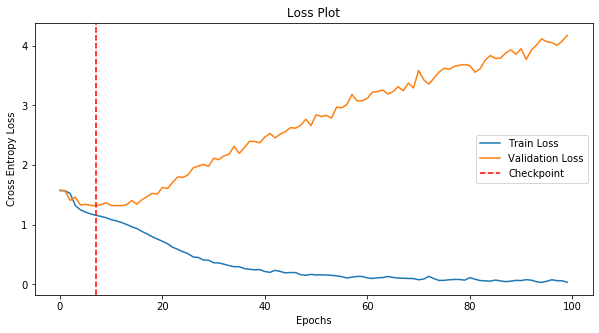

In [0]:
plt.figure(figsize=(10,5))
plt.plot(measurements["Train Loss"], label="Train Loss")
plt.plot(measurements["Val Loss"], label="Validation Loss")
plt.axvline(measurements["Lowest Val Loss Epoch"], linestyle='--', color='r',label='Checkpoint')
plt.title("Loss Plot")
plt.xlabel("Epochs")
plt.ylabel("Cross Entropy Loss")
plt.legend()

## Final Accuracies

In [0]:
testdl = data.Iterator(testds,
                        batch_size=batch_size,
                        sort_key=lambda x: len(x.Text),
                        device=device,
                        sort_within_batch=False)
test_batch_it = BatchGenerator(testdl, 'Text', 'Label')
m.eval()
loss_fn=F.cross_entropy
accuracies = []

for batch_it in [train_batch_it, val_batch_it, test_batch_it]:
  y_true = list()
  y_pred = list()
  total_loss = 0

  for (X,lengths),y in iter(batch_it):
      pred = m(X)
      loss = loss_fn(pred, y)
      pred_idx = torch.max(pred, 1)[1]

      y_true += list(y.cpu().data.numpy())
      y_pred += list(pred_idx.cpu().data.numpy())
      total_loss += loss.item()

  acc = accuracy_score(y_true, y_pred)
  accuracies.append(acc)

In [0]:
print(f'Training Accuracy: {accuracies[0]:.4f}')
print(f'Validation Accuracy: {accuracies[1]:.4f}')
print(f'Test Accuracy: {accuracies[2]:.4f}')

Training Accuracy: 0.5091
Validation Accuracy: 0.4269
Test Accuracy: 0.4416


## Test Inferences

In [0]:
# Movie reviews from:
# https://www.rottentomatoes.com/m/the_dark_knight

reviews = [
    "An exceptionally smart, brooding picture with some terrific performances.",
    "You will feel utterly numb after the screening of The Dark Knight. The film is bleak and brilliant.",
    "The definitive movie of its genre and the best Batman film to date",
    "Too much psychology and not enough pop. It's possible to be too serious, you know.",
    "One of the most stylish extravaganzas in years.",
]
field = [('Text', TEXT)]
my_examples = pd.DataFrame({'text': reviews})
my_examples.to_csv('/tmp/my_examples.csv', index=False)
my_ds = data.TabularDataset(path='/tmp/my_examples.csv', 
                            format='csv', 
                            fields=field, 
                            skip_header=True)
my_dl = data.Iterator(my_ds, batch_size=5, device=device)
my_it = BatchGenerator(my_dl, 'Text', 'Text')
m.eval()

(X,_),_ = next(iter(my_it))
pred = m(X)
pred_idx = torch.max(pred, 1)[1].cpu().data.numpy()
for i in range(len(pred_idx)):
  print("Sentiment: {}. Review: {}".format(pred_idx[i], reviews[i]))

Sentiment: 4. Review: An exceptionally smart, brooding picture with some terrific performances.
Sentiment: 4. Review: You will feel utterly numb after the screening of The Dark Knight. The film is bleak and brilliant.
Sentiment: 4. Review: The definitive movie of its genre and the best Batman film to date
Sentiment: 0. Review: Too much psychology and not enough pop. It's possible to be too serious, you know.
Sentiment: 1. Review: One of the most stylish extravaganzas in years.


## References

https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8